### Simple Assymetric Bidding Equilibrium Problem

In [11]:
using DifferentialEquations
using SpecialFunctions
using Plots

### Set Up

### Multiple (Asymmetric) Gamma Problem

We will consider a simpler version of the asymmetric bidding problem with no quadratic program on the inside.

Here, 
$$
V(s, {\alpha}, \gamma_i, p) = 1 - \exp(-\gamma (s - \alpha_i) )
$$

and so

$$
\frac{\partial V}{\partial s} = \frac{-\gamma \exp(-\gamma (s - \alpha_i) )}{1 - \exp(-\gamma (s - \alpha_i) )}
$$


#### The Problem Definition

There are $N=2$ types of bidders $i$, each of whom has some value of $\gamma$. 

We are interested in solving for the "equilibrium bidding" function that maps each possible type $(\tilde{\alpha}, {\gamma}_i)$ to a "score" $s_i(\tilde{\alpha}, {\gamma}_i)$. 

We can think the "score" function as a map:
$$
s_i : [\underline{\alpha}, \overline{\alpha}] \rightarrow [\underline{S}, \overline{S}]
$$

where each of $[\underline{\alpha}, \overline{\alpha}]$ and $[\underline{S}, \overline{S}]$ are subsets of $\mathbb{R}_{+}$. 

In order for a prospective "score" function to be an equilibrium, it needs maximize the "expected utility" from participating in the auction for each possible bidder type $(\tilde{\alpha}, \tilde{\gamma})$ --- let's call this $EU(\tilde{\alpha}, {\gamma}_i, s_i(\tilde{\alpha}))$.

This is the product of the (expected) utility that the bidder would get from completing the project if he wins (given his bid) times the probability that he wins.

$$
EU_i(\tilde{\alpha}, {\gamma}_i, s_i(\tilde{\alpha}, {\gamma}_i)) = \text{E}[u(\pi(\tilde{\alpha}, {\gamma}_i, s_i(\tilde{\alpha}, {\gamma}_i))) \text{ | win}] \times \text{Pr(win | } s_i(\tilde{\alpha}) \text{ )}
$$

 The rules of the auction are that the bidder with the **lowest** score wins the auction. Thus, we can write 
$$
\text{Pr(win | } s(\tilde{\alpha}, \tilde{\gamma}) \text{ )} = \text{Pr(} s(\tilde{\alpha}, \tilde{\gamma}) < \text{ all other bidders' scores)}
$$

That is, the probability that bidder $i$ will win using a score $s_i(\tilde{\alpha})$ is the probability that the other bidder $j$ will bid a higher score than that.

**Crucially** in equilibrium, the bidders are "best responding" to each other's score functions. 

That is:
$$
\text{Pr(} s(\tilde{\alpha}, \tilde{\gamma}) < \text{ all other bidders' scores)} = 
\text{Pr(} s_i(\tilde{\alpha}) < s_j(\alpha_j) \text{ )} \\ =
\text{Pr(} s_j^{-1}(s_i(\tilde{\alpha})) < \alpha_j \text{ )}
$$

where $\alpha_j$ is an IID random draw from the distribution of $\alpha$.

Writing $$
V(s, \hat{\alpha}, \gamma_i, p) \equiv \text{E}[u(\pi(\tilde{\alpha}, {\gamma}_i, s_i(\hat{\alpha}))) \text{ | win}]
$$
for notational ease, we can rewrite the expected utility equation above:

$$
EU_i(\tilde{\alpha}, {\gamma}_i, s_i(\tilde{\alpha})) = V_i(s, \hat{\alpha}, \gamma_i, p) \times \text{Pr(} s_j^{-1}(s_i(\tilde{\alpha})) < \alpha_j \text{ )}.
$$

We can then derive the system of differential equations by taking the first order condition:

### Boundary Value Problem ODE Definition

Denote $\psi_i(\tilde{s}) = s_i^{-1}(\tilde{s})$ for the inverse function of the mapping $s_i$.

$$
\psi_i'(s_j) = \frac{1-F(\psi_i(s_j))}{f(\psi_i(s_j))} \cdot \frac{V(s_j, \alpha_j, p)}{V'(s_j , \alpha_j, p)}
$$

where:
- Since $\psi_i(s(\alpha_i)) = s_i^{-1}(s(\alpha_i))$, we will write $\psi_i'(s(\alpha_i)) = \frac{\partial a(s_i}{\partial s)}$ interchangeably

- $f(\alpha)$ and $F(\alpha)$ are the pdf and cdf of the distrubiton with which the types $\alpha$ are distributed -- which we will assume is a uniform distribution for simplicity. 

- That is, $f(x) = \frac{1}{\overline{\alpha} - \underline{\alpha}}$ and $F(x) = \frac{x - \underline{\alpha}}{\overline{\alpha} - \underline{\alpha}}$ 

- $ V(s , \alpha, p) $ is a "value function" evaluated at $s, \alpha$ and a vector of parameters $p$. More details on this in a bit.

- $V'(s , \alpha, p) = \frac{\partial V}{\partial s} V(s , \alpha, p)$ is the derivative of the value function with respect to s.

#### Boundary Conditions

What makes this a boundary problem is:
1. The ODEs for $i$ and $j$ have to be solved together
2. Both boundary scores have to be the same: 
$$ 
s_i(\overline{\alpha}) = s_j(\overline{\alpha}) \text{  and  } s_i(\underline{\alpha}) = s_j(\underline{\alpha})
$$
3. There is a known initial condition that (supposing that $\gamma_j < \gamma_i$): 

    - $s_i(\overline{\alpha})$ must be the smallest value of $s$ s.t. $V(s , \overline{\alpha}, p) = 0 $

In [6]:
function one_minus_F_over_f_uniform(z, a, b)
    if z < a 
        out = 0
    elseif z > b
        out = 0
    else 
        out =  (b - z) 
    end
end

function one_minus_F_over_f_truncated_lognormal(z, mu, sigma, a, b)
    
    if z < a
        out = 0
    elseif z > b
        out = 0
    else 
        out = 0.5*sqrt(2)*sqrt(pi)*sigma*z
        out = out * (-erf(sqrt(2)*(mu - log(b))/(2*sigma)) + 1.0*erf(sqrt(2)*(mu - log(z))/(2*sigma)))
        out = out * exp((mu - log(z))^2/(2*sigma^2))

    end
    return(out)
end


one_minus_F_over_f_truncated_lognormal (generic function with 1 method)

In [22]:
gammas = [0.9, 1.3];
b_init = 3;
c_o = 1.2;
q_a = 5;
sigma_sq = 0.4;

alpha_max = 2.0
alpha_min = 0.5
b_max = (alpha_max*c_o)

function dinvbid_riskaverse_vanilla( b, a, g, c_o, q_a, sigma_sq)

    b_min_c = b - a*c_o; # a for alpha

    profit_ce = b_min_c;
    
    exp_profit_term = exp(g*profit_ce) - 1.0;
    
    profit_component = profit_ce > 0 ?  g / exp_profit_term : 0; # Note: this should be a scalar; if b = alpha*c so that profits are 0, this is 0

    return profit_component

end

function ode_asymmetric_riskaverse_vanilla!(da,a,p, b)
    a_1, a_2 = a;  
    
    gammas, c_o, q_a, sigma_sq = p
    
    oneMinusFoverf(x) = one_minus_F_over_f_truncated_lognormal(x, 0.0, 0.18, 0.5, 2.0)
    
    dprofit(x, g) = dinvbid_riskaverse_vanilla( b, x, g, c_o, q_a, sigma_sq)
    
    if a_1 >= 2.0 || a_1 < 0.5 
        da[1] = 0
    else
        da[1] = oneMinusFoverf(a_1) * dprofit(a_2, gammas[2])
    end
    
    if a_2 >= 2.0  || a_2 < 0.5 
        da[2] = 0
    else
        da[2] = oneMinusFoverf(a_2) * dprofit(a_1, gammas[1])
    end
    
end

# end

function is_strictly_monotone(sol)
           tmp = sol.u[1] .- 1
           for u in sol.u
               ismono = all(x->x[1] > x[2], zip(u, tmp))
               ismono || return false
               copyto!(tmp, u)
           end
           return true
       end

function test_convergence_critereon(ode_sol)
    a_1_end, a_2_end = ode_sol.u[end]
    
    ## Idea: if the solution is INVALID --> increase b_min_guess; otherwise decrease.
    
    if(max(a_1_end, a_2_end) > alpha_max || min(a_1_end, a_2_end) < alpha_min || (~ is_strictly_monotone(guessed_sol)) )
        return(2) # Need to decrease b_min
    else
        if(abs(a_1_end - a_2_end) < 0.01) 
           if(abs(a_1_end - alpha_max) < 0.01)
                return(0) # converged
            end
        end
        return(1) # Need to increase b_min
    end
end




function vanilla_riskaverse_shoot(b_min_ub,b_min_lb)
    new_b_min_guess = (b_min_ub + b_min_lb)/2
    b_span = (new_b_min_guess, b_max) ## the left boundary (b_min) is the one we don't know
    v_init = [alpha_min, alpha_min]
    ivb = ODEProblem(ode_asymmetric_riskaverse_vanilla!,v_init, b_span, [gammas, c_o, q_a, sigma_sq])
    guessed_sol = solve(ivb, Rodas5())
    new_converged_status = test_convergence_critereon(guessed_sol)
    return(new_b_min_guess, new_converged_status)
end

## Attempt at a bisection search algo to find b_max


b_min_ub = (alpha_max*c_o)
b_min_lb = (alpha_min*c_o)

max_iter = 200
b_min_guess = (b_min_ub + b_min_lb)/2

b_span = (b_min_guess, b_max) ## the left boundary (b_min) is the one we don't know
v_init = [alpha_min,alpha_min]
ivb = ODEProblem(ode_asymmetric_riskaverse_vanilla!,v_init, b_span, [gammas, c_o, q_a, sigma_sq])
guessed_sol = solve(ivb, Rodas5())
# guessed_sol = solve(ivb, AutoTsit5(Rosenbrock23()))
converged_status = test_convergence_critereon(guessed_sol)
num_iter = 1
println("Iter: ",0,": new_converged_status: ", converged_status, "; b_min_guess: ", b_min_guess, "; b_min_ub: ", b_min_ub, "; b_min_lb: ", b_min_lb)

finished = 0
while finished == 0 && num_iter < max_iter 
    if converged_status == 1 ## need to decrease
        new_b_min_ub = b_min_guess;    
        (new_b_min_guess, new_converged_status) = vanilla_riskaverse_shoot(new_b_min_ub, b_min_lb);
        b_min_ub = new_b_min_ub;
        println("Iter: ",num_iter,": new_converged_status: ", new_converged_status, "; b_min_guess: ", new_b_min_guess, "; b_min_ub: ", b_min_ub, "; b_min_lb: ", b_min_lb)
        converged_status = new_converged_status;
        if (abs(new_b_min_guess - b_min_guess) == 0)
            finished = 1;
            println("Converged because the b_min_guess is no longer changing")
        else 
            b_min_guess = new_b_min_guess;
            num_iter = num_iter + 1;
        end
    elseif converged_status == 2 ## need to increase
        new_b_min_lb = b_min_guess;
        (new_b_min_guess, new_converged_status) = vanilla_riskaverse_shoot(b_min_ub, new_b_min_lb);
        b_min_lb = new_b_min_lb;
        println("Iter: ",num_iter,": new_converged_status: ", new_converged_status, "; b_min_guess: ", new_b_min_guess, "; b_min_ub: ", b_min_ub, "; b_min_lb: ", b_min_lb)
        converged_status = new_converged_status;
#         b_min_guess = new_b_min_guess;
#         num_iter = num_iter + 1;
        if (abs(new_b_min_guess - b_min_guess) == 0)
            finished = 1;
            println("Converged because the b_min_guess is no longer changing")
        else 
            b_min_guess = new_b_min_guess;
            num_iter = num_iter + 1;
        end
    elseif converged_status == 0
        println("Converged! b_min is: ", b_min_guess)
        b_span = (b_min_guess, b_max) ## the left boundary (b_min) is the one we don't know
        ivb = ODEProblem(ode_asymmetric_riskaverse_vanilla!,v_init, b_span, [gammas, c_o, q_a, sigma_sq])
        final_sol = solve(ivb, Rodas5())
        println("b_min: ", b_min_guess, "; a_1(b_min), a_2(b_min): ", final_sol.u[end])
#         plot(final_sol)
        finished = 1
    end
end

Iter: 0: new_converged_status: 1; b_min_guess: 1.5; b_min_ub: 2.4; b_min_lb: 0.6
Iter: 1: new_converged_status: 2; b_min_guess: 1.05; b_min_ub: 1.5; b_min_lb: 0.6
Iter: 2: new_converged_status: 1; b_min_guess: 1.275; b_min_ub: 1.5; b_min_lb: 1.05
Iter: 3: new_converged_status: 2; b_min_guess: 1.1625; b_min_ub: 1.275; b_min_lb: 1.05
Iter: 4: new_converged_status: 1; b_min_guess: 1.21875; b_min_ub: 1.275; b_min_lb: 1.1625
Iter: 5: new_converged_status: 2; b_min_guess: 1.190625; b_min_ub: 1.21875; b_min_lb: 1.1625
Iter: 6: new_converged_status: 1; b_min_guess: 1.2046875; b_min_ub: 1.21875; b_min_lb: 1.190625
Iter: 7: new_converged_status: 1; b_min_guess: 1.19765625; b_min_ub: 1.2046875; b_min_lb: 1.190625
Iter: 8: new_converged_status: 1; b_min_guess: 1.1941406250000002; b_min_ub: 1.19765625; b_min_lb: 1.190625
Iter: 9: new_converged_status: 2; b_min_guess: 1.1923828125; b_min_ub: 1.1941406250000002; b_min_lb: 1.190625
Iter: 10: new_converged_status: 2; b_min_guess: 1.19326171875; b_min_u

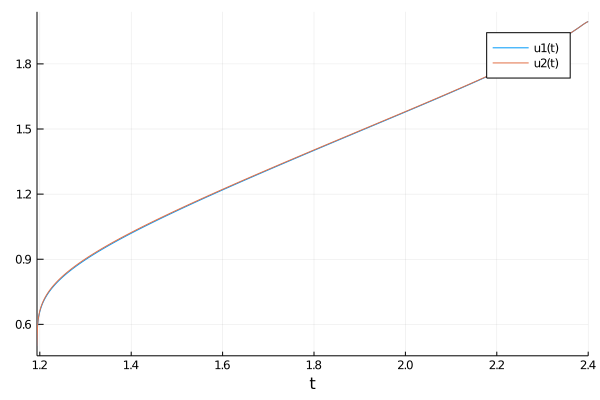

In [21]:
plot(final_sol)

## A closer example to what we have but without the quadratic program

In [18]:

gammas = [1.54, 1.5];
b_init = 3;
c_o = 1.2;
q_a = 5;
sigma_sq = 0.4;

alpha_max = 2.0
alpha_min = 0.5
b_max = (alpha_max*c_o)

function dinvbid_riskaverse_one_item( b, a, g, c_o, q_a, sigma_sq)

    b_min_c = b - a*c_o; # a for alpha

    profit_ce = (q_a * b_min_c) - (g)*0.5 * ((sigma_sq .* b_min_c) * b_min_c)
    exp_profit_term = exp(g*profit_ce) - 1.0;


    dce = ((g .* q_a) - (g^2 .* sigma_sq .* b_min_c) );
    
    profit_component = profit_ce > 0 ?  dce / exp_profit_term : 0; # Note: this should be a scalar; if b = alpha*c so that profits are 0, this is 0

    return profit_component

end

function ode_asymmetric_riskaverse_oneitem!(da,a,p, b)
    a_1, a_2 = a;  
    
    gammas, c_o, q_a, sigma_sq = p
#     print((gammas, c_o, q_a, sigma_sq))
    
    oneMinusFoverf(x) = one_minus_F_over_f_truncated_lognormal(x, 0.0, 0.2, 0.5, 2.0)
    
    dprofit(x, g) = dinvbid_riskaverse_one_item( b, x, g, c_o, q_a, sigma_sq)
    
    if a_1 >= 2.0 || a_1 < 0.5 
        da[1] = 0
    else
        da[1] = oneMinusFoverf(a_1) * dprofit(a_2, gammas[2])
    end
    
    if a_2 >= 2.0  || a_2 < 0.5 
        da[2] = 0
    else
        da[2] = oneMinusFoverf(a_2) * dprofit(a_1, gammas[1])
    end
    
#     return(da)

end

function is_strictly_monotone(sol)
           tmp = sol.u[1] .- 1
           for u in sol.u
               ismono = all(x->x[1] > x[2], zip(u, tmp))
               ismono || return false
               copyto!(tmp, u)
           end
           return true
       end

function test_convergence_critereon(ode_sol)
    a_1_end, a_2_end = ode_sol.u[end]
    
    ## Idea: if the solution is INVALID --> increase b_min_guess; otherwise decrease.
    
    if(max(a_1_end, a_2_end) > alpha_max || min(a_1_end, a_2_end) < alpha_min || (~ is_strictly_monotone(guessed_sol)) )
        return(2) # Need to decrease b_min
    else
        if(abs(a_1_end - a_2_end) < 0.01) 
           if(abs(a_1_end - alpha_max) < 0.01)
                return(0) # converged
            end
        end
        return(1) # Need to increase b_min
    end
end




function oneitem_riskaverse_shoot(b_min_ub,b_min_lb)
    new_b_min_guess = (b_min_ub + b_min_lb)/2
    b_span = (new_b_min_guess, b_max) ## the left boundary (b_min) is the one we don't know
    v_init = [alpha_min, alpha_min]
    ivb = ODEProblem(ode_asymmetric_riskaverse_oneitem!,v_init, b_span, [gammas, c_o, q_a, sigma_sq])
    guessed_sol = DifferentialEquations.solve(ivb, Rodas5())
    new_converged_status = test_convergence_critereon(guessed_sol)
    return(new_b_min_guess, new_converged_status)
end

## Attempt at a bisection search algo to find b_max


b_min_ub = (alpha_max*c_o)
b_min_lb = (alpha_min*c_o)

max_iter = 200
b_min_guess = (b_min_ub + b_min_lb)/2

b_span = (b_min_guess, b_max) ## the left boundary (b_min) is the one we don't know
v_init = [alpha_min,alpha_min]
ivb = ODEProblem(ode_asymmetric_riskaverse_oneitem!,v_init, b_span, [gammas, c_o, q_a, sigma_sq])
guessed_sol = DifferentialEquations.solve(ivb, Rodas5())
converged_status = test_convergence_critereon(guessed_sol)
num_iter = 1
println("Iter: ",0,": new_converged_status: ", converged_status, "; b_min_guess: ", b_min_guess, "; b_min_ub: ", b_min_ub, "; b_min_lb: ", b_min_lb)

finished = 0
while finished == 0 && num_iter < max_iter 
    if converged_status == 1 ## need to decrease
        new_b_min_ub = b_min_guess;    
        (new_b_min_guess, new_converged_status) = oneitem_riskaverse_shoot(new_b_min_ub, b_min_lb);
        b_min_ub = new_b_min_ub;
        println("Iter: ",num_iter,": new_converged_status: ", new_converged_status, "; b_min_guess: ", new_b_min_guess, "; b_min_ub: ", b_min_ub, "; b_min_lb: ", b_min_lb)
        converged_status = new_converged_status;
        if (abs(new_b_min_guess - b_min_guess) == 0)
            finished = 1;
            println("Converged because the b_min_guess is no longer changing")
        else 
            b_min_guess = new_b_min_guess;
            num_iter = num_iter + 1;
        end
    elseif converged_status == 2 ## need to increase
        new_b_min_lb = b_min_guess;
        (new_b_min_guess, new_converged_status) = oneitem_riskaverse_shoot(b_min_ub, new_b_min_lb);
        b_min_lb = new_b_min_lb;
        println("Iter: ",num_iter,": new_converged_status: ", new_converged_status, "; b_min_guess: ", new_b_min_guess, "; b_min_ub: ", b_min_ub, "; b_min_lb: ", b_min_lb)
        converged_status = new_converged_status;
        if (abs(new_b_min_guess - b_min_guess) == 0)
            finished = 1;
            println("Converged because the b_min_guess is no longer changing")
        else 
            b_min_guess = new_b_min_guess;
            num_iter = num_iter + 1;
        end
    elseif converged_status == 0
        println("Converged! b_min is: ", b_min_guess)
        finished = 1
    end
    
end

b_span = (b_min_guess, b_max) ## the left boundary (b_min) is the one we don't know
ivb = ODEProblem(ode_asymmetric_riskaverse_oneitem!,v_init, b_span, [gammas, c_o, q_a, sigma_sq])
final_sol = DifferentialEquations.solve(ivb, Rodas5())
println("b_min: ", b_min_guess, "; a_1(b_min), a_2(b_min): ", final_sol.u[end])

Iter: 0: new_converged_status: 1; b_min_guess: 1.5; b_min_ub: 2.4; b_min_lb: 0.6
Iter: 1: new_converged_status: 2; b_min_guess: 1.05; b_min_ub: 1.5; b_min_lb: 0.6
Iter: 2: new_converged_status: 1; b_min_guess: 1.275; b_min_ub: 1.5; b_min_lb: 1.05
Iter: 3: new_converged_status: 1; b_min_guess: 1.1625; b_min_ub: 1.275; b_min_lb: 1.05
Iter: 4: new_converged_status: 1; b_min_guess: 1.1062500000000002; b_min_ub: 1.1625; b_min_lb: 1.05
Iter: 5: new_converged_status: 1; b_min_guess: 1.078125; b_min_ub: 1.1062500000000002; b_min_lb: 1.05
Iter: 6: new_converged_status: 1; b_min_guess: 1.0640625; b_min_ub: 1.078125; b_min_lb: 1.05
Iter: 7: new_converged_status: 1; b_min_guess: 1.05703125; b_min_ub: 1.0640625; b_min_lb: 1.05
Iter: 8: new_converged_status: 2; b_min_guess: 1.0535156250000002; b_min_ub: 1.05703125; b_min_lb: 1.05
Iter: 9: new_converged_status: 1; b_min_guess: 1.0552734375000001; b_min_ub: 1.05703125; b_min_lb: 1.0535156250000002
Iter: 10: new_converged_status: 1; b_min_guess: 1.0543

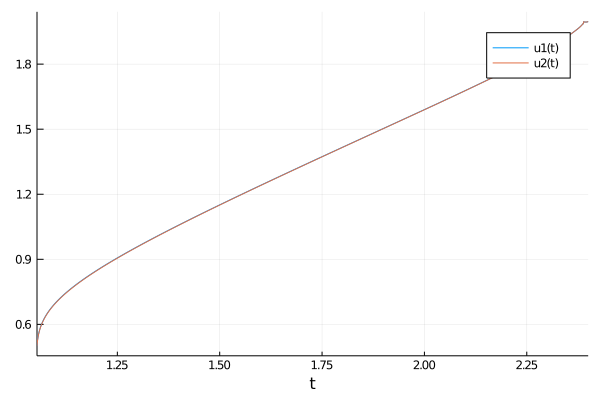

In [19]:
plot(final_sol)

### More Attempts at Alternatives  

In [ ]:
function ode_asymmetric_riskaverse_vanilla(a,p, b)
    a_1, a_2 = a;  
    
    da = a
    
    gammas, c_o, q_a, sigma_sq = p
    
    oneMinusFoverf(x) = one_minus_F_over_f_truncated_lognormal(x, 0.0, 0.18, 0.5, 2.0)
    
    dprofit(x, g) = dinvbid_riskaverse_vanilla( b, x, g, c_o, q_a, sigma_sq)
    
    if a_1 >= 2.0 || a_1 < 0.5 
        da[1] = 0
    else
        da[1] = oneMinusFoverf(a_1) * dprofit(a_2, gammas[2])
    end
    
    if a_2 >= 2.0  || a_2 < 0.5 
        da[2] = 0
    else
        da[2] = oneMinusFoverf(a_2) * dprofit(a_1, gammas[1])
    end
    
    return(da)
    
end

function asymmetric_obj!(a, starting_b, p)
    
    gammas, c_o, q_a, sigma_sq = p
    
    b_step_size = (b_max - starting_b)/5
    b_steps = starting_b:b_step_size:b_max
    
    resids = [(ode_asymmetric_riskaverse_vanilla(a[t] - ), p, b_steps[t])  for t=1:5]
    
    print(resids)
    
    
end

a_steps = (2.0-0.5)/10
a_test = [ [0.5, 0.5], [0.9, 0.9], [1.5, 1.5], [1.8, 1.8], [2.0, 2.0] ]

# ode_asymmetric_riskaverse_vanilla([0.9, 0.9],[gammas, c_o, q_a, sigma_sq], 1.9)

asymmetric_obj!(a_test, 1.1938540711998944, [gammas, c_o, q_a, sigma_sq])